## Documents the module reco_functions.py

In [105]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

#### General

In [1]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D 
import networkx as nx
from itertools   import combinations

In [2]:
from pandas import DataFrame, Series
from typing import List, Tuple
from typing import Union
from   dataclasses import dataclass

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

In [5]:
idx = pd.IndexSlice

#### IC

In [6]:

import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


#### TICs

In [7]:
from tics.histograms    import h1
from tics.pd_tics       import get_index_slice_from_multi_index
from tics.graphics_reco import plot_hits3d
from tics.graphics_reco import plot_hits3d_and_true_extrema
from tics.stats_tics    import bin_data_with_equal_bin_size
from tics.util_tics import get_class_name
from tics.util_tics import Range
from tics.graphics_reco import plot_gtrack
from tics.system_of_units import *

#### NetFlex

In [8]:
from nextflex.core import Setup

In [11]:
from nextflex.core import Setup
from nextflex.mctrue_functions import get_mc_particles
from nextflex.mctrue_functions import get_mc_primary_particles
from nextflex.mctrue_functions import get_mc_vertex
from nextflex.mctrue_functions import select_mc_particles
from nextflex.mctrue_functions import get_mc_hits
from nextflex.mctrue_functions import select_mc_hits
from nextflex.mctrue_functions import total_hit_energy
from nextflex.mctrue_functions import get_event_hits_from_mchits
from nextflex.mctrue_functions import get_true_extrema
from nextflex.mctrue_functions import get_particle_ids_from_mchits
from nextflex.mctrue_functions import get_hit_ids_from_mchits

In [12]:
from nextflex.reco_functions import voxelize_hits
from nextflex.reco_functions import get_voxels_as_list
from nextflex.reco_functions import voxel_position
from nextflex.reco_functions import voxel_energy
from nextflex.reco_functions import voxel_nhits
from nextflex.reco_functions import distance_between_two_voxels
from nextflex.reco_functions import voxel_distances
from nextflex.reco_functions import voxel_distance_pairs
from nextflex.reco_functions import make_track_graphs
from nextflex.reco_functions import gtrack_voxels
from nextflex.reco_functions import shortest_paths
from nextflex.reco_functions import find_extrema_and_length
from nextflex.reco_functions import GTrack
from nextflex.reco_functions import voxels_in_blob
from nextflex.reco_functions import blob_energy

### Input data

In [13]:
FDATA = os.environ['FLEXDATA']

### test file

In [14]:
testFilebb      = os.path.join(FDATA,"testData",
                            'FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.0.next.h5')
testFile1e      = os.path.join(FDATA,"testData",
                            'FLEX100_M6_O6.e-.ACTIVE.1000.next.h5')


### mctrue functions

#### McHits

##### For a bbonu file

In [15]:
mcHits_bb = get_mc_hits(testFilebb)
mcHits_bb

<McHits>
        Columns = ('x', 'y', 'z', 'time', 'energy', 'label')
        Indexes = ('event_id', 'particle_id', 'hit_id')
        

In [16]:
mcHits_bb.event_list()

array([0, 1, 2, 3])

In [17]:
mcHits_bb.df

x           y           z      time  \
event_id particle_id hit_id                                                 
0        1           0      -270.746246 -240.824417  724.598206  0.003517   
                     1      -271.566711 -240.745667  724.041504  0.007034   
                     2      -272.361237 -240.716476  723.438293  0.010564   
                     3      -273.137329 -240.716278  722.811584  0.014101   
                     4      -273.232025 -240.705490  722.708618  0.014599   
...                                 ...         ...         ...       ...   
3        83631883    77      361.853577   76.278801  991.085022  0.180530   
                     78      361.854279   76.278984  991.085205  0.180554   
                     79      361.854858   76.279205  991.085327  0.180574   
                     80      361.854950   76.279205  991.085815  0.180591   
                     81      361.854919   76.279099  991.086670  0.180629   

                               energy   label  
event_id particle_id hit_id                    
0        1           0       0.005752  ACTIVE  
                     1       0.006912  ACTIVE  
                     2       0.025096  ACTIVE  
                     3       0.007589  ACTIVE  
                     4       0.000587  ACTIVE  
...                               ...     ...  
3        83631883    77      0.000109  ACTIVE  
                     78      0.000363  ACTIVE  
                     79      0.000117  ACTIVE  
                     80      0.000899  ACTIVE  
                     81      0.001552  ACTIVE  

[2319 rows x 6 columns]

In [18]:
mcHits_1e = get_mc_hits(testFile1e)
mcHits_1e

<McHits>
        Columns = ('x', 'y', 'z', 'time', 'energy', 'label')
        Indexes = ('event_id', 'particle_id', 'hit_id')
        

In [19]:
mcHits_1e.df

x           y           z      time  \
event_id particle_id hit_id                                                 
5000     1           0      -459.471741   35.686749  680.406738  0.003376   
                     1      -460.011810   36.272388  679.806702  0.006753   
                     2      -460.630341   36.872669  679.305908  0.010129   
                     3      -461.301666   37.448700  678.840576  0.013514   
                     4      -461.951935   38.031681  678.373108  0.016870   
...                                 ...         ...         ...       ...   
5004     107284662   105    -108.350067  197.361862  823.132751  0.361198   
                     106    -108.351059  197.362000  823.133057  0.361227   
                     107    -108.352043  197.362106  823.133240  0.361256   
                     108    -108.353806  197.362274  823.133545  0.361308   
                     109    -108.353615  197.362976  823.132996  0.361349   

                               energy   label  
event_id particle_id hit_id                    
5000     1           0       0.009271  ACTIVE  
                     1       0.006503  ACTIVE  
                     2       0.003626  ACTIVE  
                     3       0.007412  ACTIVE  
                     4       0.009619  ACTIVE  
...                               ...     ...  
5004     107284662   105     0.000453  ACTIVE  
                     106     0.000188  ACTIVE  
                     107     0.000017  ACTIVE  
                     108     0.001673  ACTIVE  
                     109     0.001821  ACTIVE  

[2226 rows x 6 columns]

In [20]:
mcHits_1e.event_list()

array([5000, 5001, 5002, 5003, 5004])

#### EventHits

In [21]:
eventHitsbb = get_event_hits_from_mchits(mcHits_bb, event_id=0, particle_type='all')

In [22]:
eventHitsbb

<EventHits>
        event number = 0
        Columns = ('x', 'y', 'z', 'energy')
        

In [23]:
eventHitsbb.df.energy.sum()

2.4578302

In [24]:
eventHits1e = get_event_hits_from_mchits(mcHits_1e, event_id=5001, particle_type='all')

In [25]:
eventHits1e

<EventHits>
        event number = 5001
        Columns = ('x', 'y', 'z', 'energy')
        

In [26]:
eventHits1e.df.energy.sum()

2.320686

#### True Extremes

In [27]:
tebb = get_true_extrema(mcHits_bb, event_id= 0, event_type = "bb0nu")

In [28]:
tebb.df

,x,y,z,time,energy,label
0,-273.207062,-255.572342,724.871460,0.348872,0.001073,ACTIVE
1,-261.039703,-230.863617,792.874023,0.523512,0.002869,ACTIVE


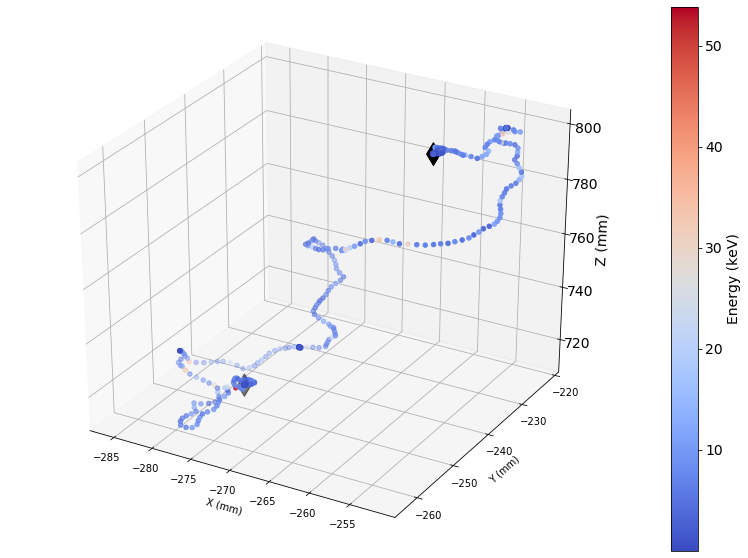

In [29]:
plot_hits3d_and_true_extrema(eventHitsbb.df, tebb.df, autorange = True, figsize   = (14,10))

In [103]:
te1e = get_true_extremes(mcHits_1e, event_id= 5001, event_type = "1e")

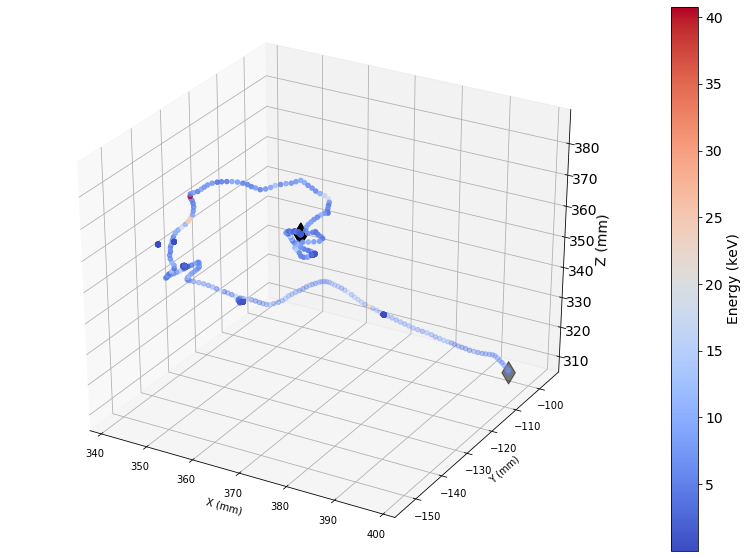

In [104]:
plot_hits3d_and_true_extrema(eventHits1e.df, te1e.df, autorange = True, figsize   = (14,10))

### reco functions

#### Voxelize

- To voxelize a set of hits (defined by x,y,z,energy), one needs to do the following:
    - Define voxels (e.g, cubic volumes) by dividing the space in 3d bins 
    - Group all the hits contained in the voxel. 

- The voxel has fields (x,y,z,energy, nhits), where nhits is the number of hits used to form the track and
the (x,y,z) of the voxels are the barycenters of the hits: e.g, 

$x_v = \frac{\sum x_i e_i}{\sum e_i}$, where:

$x_v=(x,y,z)$ of the voxel

$x_i=(x,y,z)$ of each hit in the voxel, $e_i$ is the energy of each hit in the voxel

The energy of the voxel is the sum of the energies of the hits, $e_v = \sum e_i$

***
def voxelize_hits(hits     : EventHits,
                  bin_size : int,
                  baryc    : bool = True)->Tuple[VoxelHits, VoxelInfo]:
                  
    """
    Takes a EventHits objects wit fields (x,y,z,energy)
    voxelize the data in cubic voxels of size bin_size and return a
    Tuple with two objects:

    1. A VoxelHits object, which includes the field nhits (number of hits)
    used to form the voxel. If the field barycenter is True,
    compute the (x, y, z) position of the voxel as the baryc
    of the hits, otherwise as the mean of the positions of the hits.

    2. A VoxelInfo object which contains information concering the
    voxelisation.

    """
***

##### Using barycenter to define the hit position

In [111]:
voxelHitsbb, voxelInfobb = voxelize_hits(eventHitsbb, bin_size = 1, baryc = True)

In [112]:
voxelHitsbb.df.head()

,x,y,z,energy,nhits
0,-285.018433,-248.666336,721.137085,0.009695,1.0
1,-285.166626,-247.589310,718.438232,0.005763,1.0
2,-285.651343,-247.766070,719.511444,0.006362,8.0
3,-285.326538,-248.255112,720.280457,0.003507,1.0
4,-284.336962,-249.569081,721.941468,0.015284,2.0


In [113]:
len(voxelHitsbb.df)

206

In [114]:
voxelInfobb

VoxelInfo(xyz_bins=0.130935, bin_size=1)

In [115]:
voxelHits1e, voxelInfo1e = voxelize_hits(eventHits1e, bin_size = 1, baryc = True)

In [116]:
voxelHits1e.df.head()

,x,y,z,energy,nhits
0,342.438843,-130.186325,338.023041,0.006450,1.0
1,342.175232,-129.499146,337.346924,0.005069,1.0
2,341.999176,-128.744385,336.721375,0.008573,1.0
3,342.271729,-127.624512,335.653107,0.006620,1.0
4,343.533600,-131.804367,340.275940,0.019106,1.0


In [117]:
len(voxelHits1e.df)

229

In [118]:
voxelInfo1e

VoxelInfo(xyz_bins=0.260072, bin_size=1)

##### Using hit average as positions

In [119]:
aVoxelHitsbb, aVoxelInfobb = voxelize_hits(eventHitsbb, bin_size = 1, baryc = False)

In [120]:
aVoxelInfobb

VoxelInfo(xyz_bins=0.130935, bin_size=1)

##### Comparing barycenter and average (results are very close)

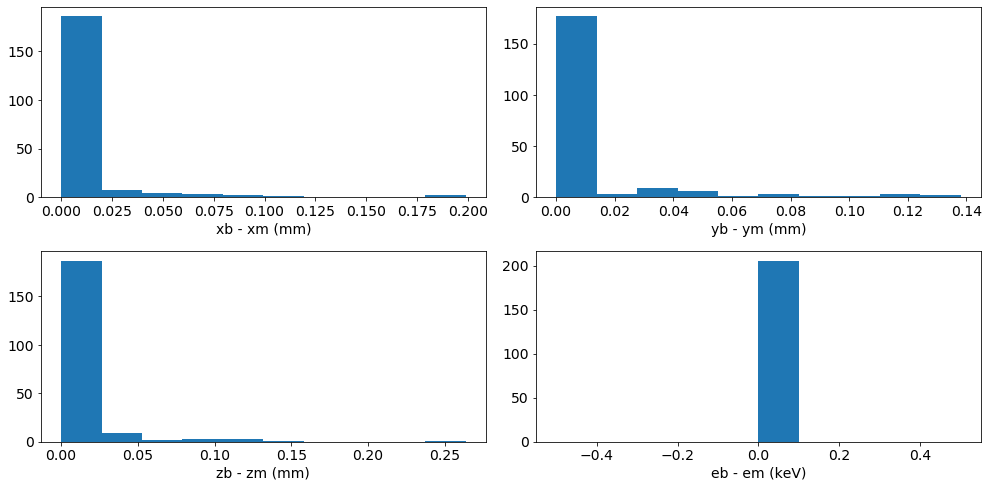

In [125]:
fig = plt.figure(figsize=(14,7))
ax      = fig.add_subplot(2, 2, 1)
out = plt.hist(np.abs(aVoxelHitsbb.df.x.values - voxelHitsbb.df.x.values))
plt.xlabel("xb - xm (mm)")
ax      = fig.add_subplot(2, 2, 2)
out = plt.hist(np.abs(aVoxelHitsbb.df.y.values - voxelHitsbb.df.y.values))
plt.xlabel("yb - ym (mm)")
ax      = fig.add_subplot(2, 2, 3)
out = plt.hist(np.abs(aVoxelHitsbb.df.z.values - voxelHitsbb.df.z.values))
plt.xlabel("zb - zm (mm)")
ax      = fig.add_subplot(2, 2, 4)
out = plt.hist(np.abs(aVoxelHitsbb.df.energy.values/keV - voxelHitsbb.df.energy.values/keV))
plt.xlabel("eb - em (keV)")
plt.tight_layout()
plt.show()

##### Correlation between energy and number of hits

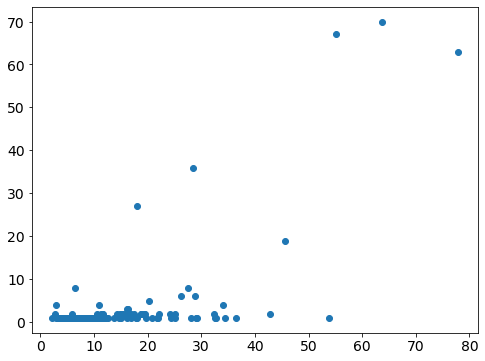

In [126]:
plt.scatter(voxelHitsbb.df.energy/keV, voxelHitsbb.df.nhits )

##### Correlation between voxel z position and energy

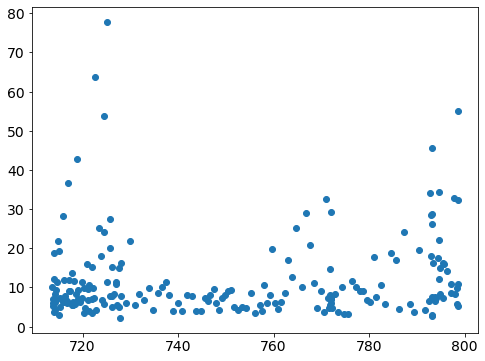

In [127]:
plt.scatter(voxelHitsbb.df.z, voxelHitsbb.df.energy/keV)

#### Draw voxelized hits

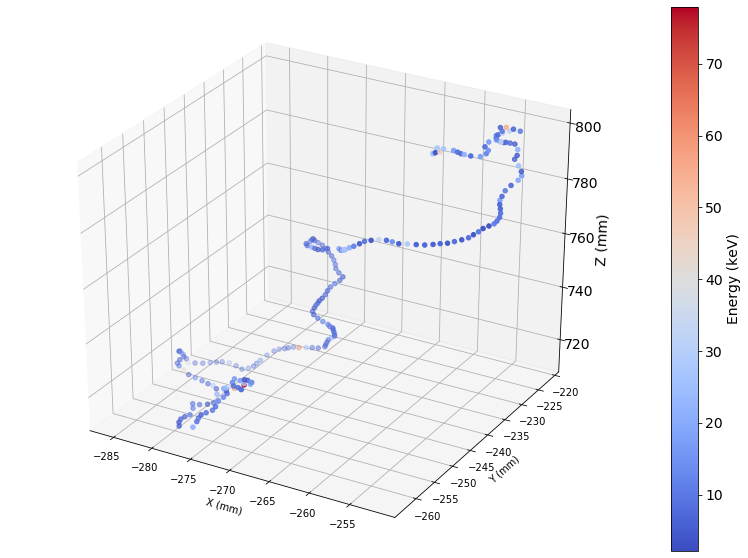

In [128]:
plot_hits3d(voxelHitsbb.df, autorange = True, figsize   = (14,10))

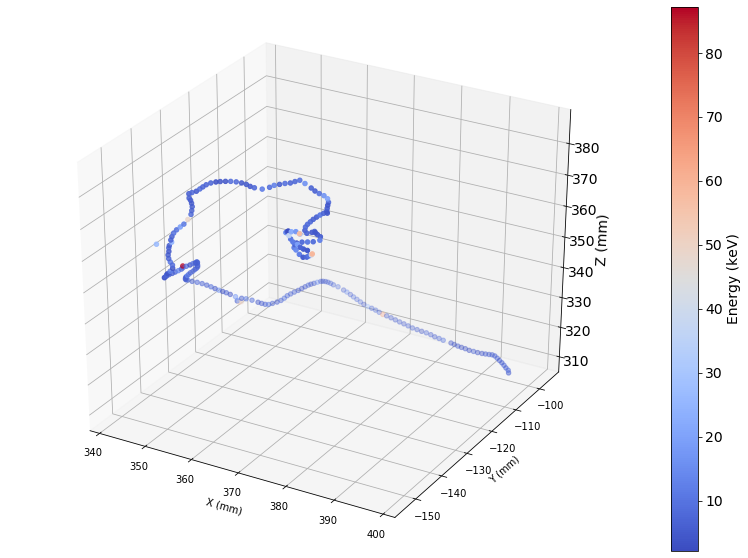

In [129]:
plot_hits3d(voxelHits1e.df, autorange = True, figsize   = (14,10))

### Organise hits into a track

- The next step is to organise the voxels into a track. One way to do this is to define a graph.
***

def make_track_graphs(voxels : List[Voxel], contiguity : float)->List[nx.Graph]:

    """
    Make "graph-tracks" (gtracks) using networkx:

    1. Define a graph such that each voxel is a node and there is a link
    (or edge) between each pair of nodes which are at a distance smaller
    than defined by contiguity.

    2. Return a list of graphs made with connected components. Each connected
    component graph is made of a set of connected nodes (eg. nodes which are
    at a distance smaller than contiguity)

    """
***

- The function above uses **networkx** which needs a list of voxels: ((x0,y0,z0,e0), (x1,y1,z1,e1)...))
- Therefore is convenient to define a Voxel type as a simple pseudonim for a List of Tuples of float

***
Voxel = TypeVar('Voxel', Tuple[float], np.array)  # define voxel as type
***

- And a utility function that produces the voxels from the hits

***
def get_voxels_as_list(voxelHits : VoxelHits)->List[Voxel]:

    """
    Return the voxels as a list of tuples with the coordinates
    (this is needed for networkx)

    """

def position(v : Voxel)->np.array:

    """
    Return the position of a voxel as a numpy array

    """

def distance(va : Voxel, vb : Voxel)->float:

    """
    Return the distance between two voxels

    """

def voxel_distances(voxels : List[Voxel])->Tuple[np.array]:

    """
    Return a numpy array with the distance (inclusive) between any pair
    of voxels, and another array with the minimum distance between a
    voxel and all the others.

    """

def voxel_distance_pairs(voxels : List[Voxel])->Tuple[np.array]:

    """
    Return a numpy array with the distance (inclusive) between any pair
    of voxels, use a list conprehension.

    """
***

#### Compute inclusive distance between any pair of voxels and minimum distance between a voxel and any other voxel

In [130]:
voxels = get_voxels_as_list(voxelHitsbb)

In [131]:
minimum_d, inclusive_d = voxel_distances(voxels)

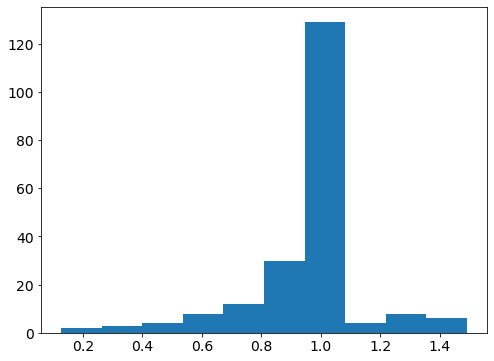

In [132]:
out = plt.hist(minimum_d)

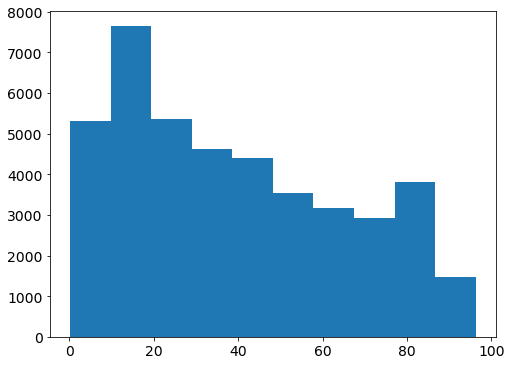

In [133]:
out = plt.hist(inclusive_d)

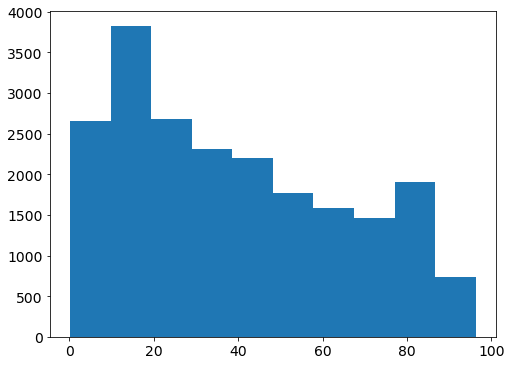

In [134]:
out = plt.hist(voxel_distance_pairs(voxels))

### Define gtracks (graph tracks)

***
def make_track_graphs(voxels : List[Voxel], contiguity : float)->List[nx.Graph]:

    """
    Make "graph-tracks" (gtracks) using networkx:

    1. Define a graph such that each voxel is a node and there is a link
    (or edge) between each pair of nodes which are at a distance smaller
    than defined by contiguity. 

    2. Return a list of graphs made with connected components. Each connected
    component graph is made of a set of connected nodes (eg. nodes which are 
    at a distance smaller than contiguity)

    """
***

#### First example. Take a large value of contiguity (10 mm)

In [136]:
contiguity = 3
gtracks = make_track_graphs(voxels, contiguity)
print(f'number of tracks for contiguity of {contiguity} is {len(gtracks)}')

number of tracks for contiguity of 3 is 1


In [137]:
gtv = gtrack_voxels(gtracks[0], event_id=0)
gtv

<VoxelHits>
        event number = 0
        Columns = ('x', 'y', 'z', 'energy', 'nhits')
        

In [138]:
gtvdf = gtv.df

In [139]:
gtvdf.head()

,x,y,z,energy,nhits
0,-285.018433,-248.666336,721.137085,0.009695,1.0
1,-285.166626,-247.589310,718.438232,0.005763,1.0
2,-285.651343,-247.766070,719.511444,0.006362,8.0
3,-285.326538,-248.255112,720.280457,0.003507,1.0
4,-284.336962,-249.569081,721.941468,0.015284,2.0


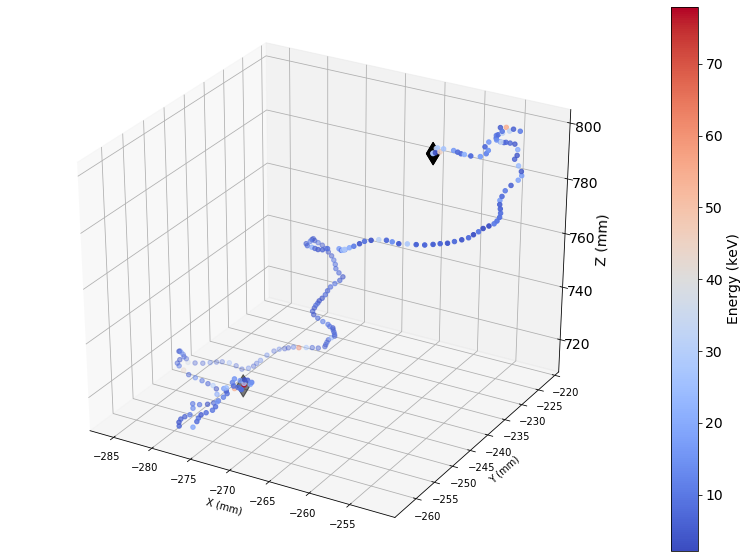

In [141]:
plot_hits3d_and_true_extrema(gtvdf, tebb.df, autorange = True, figsize   = (14,10))

### Create a GTrack object
- A gtrack takes a graph track and computes the extrema and track length. 

***

@dataclass

class GTrack:

    """
    A graph-track
    gt       : a nx Graph representing the track
    event_id : event number
    ea       : extreme "a"
    eb       : extreme "b"
    length   : track length 
    """
    gt       : nx.Graph 
    # rb       : float # blob radius 
    event_id : int
        
    def __post_init__(self):
        self.extrema = {}
        self.voxels     = get_voxels_as_list(gtrack_voxels(self.gt, self.event_id)) 
        self.voxels_df  = pd.DataFrame(self.voxels, columns =['x', 'y', 'z', 'energy', 'nhits'])
        self.distances  = shortest_paths(self.gt)
        e1, e2, self.length = find_extrema_and_length_from_dict(self.distances) #extrema 1 and 2
        self.extrema['e1'] = e1
        self.extrema['e2'] = e2
    

def voxels_in_blob(gt : GTrack, rb : float, extreme : str ='e1')->VoxelHits:

    """
    Return the a VoxelHits object with the voxels contained in a blob
    of radius rb around the extreme.
    
    """

def blob_energy(gt : GTrack, rb : float, extreme : str ='e1', unit=keV)->float:

    """
    Return the total energy contained in a blob of radius rb around
    the extreme.

    """

***

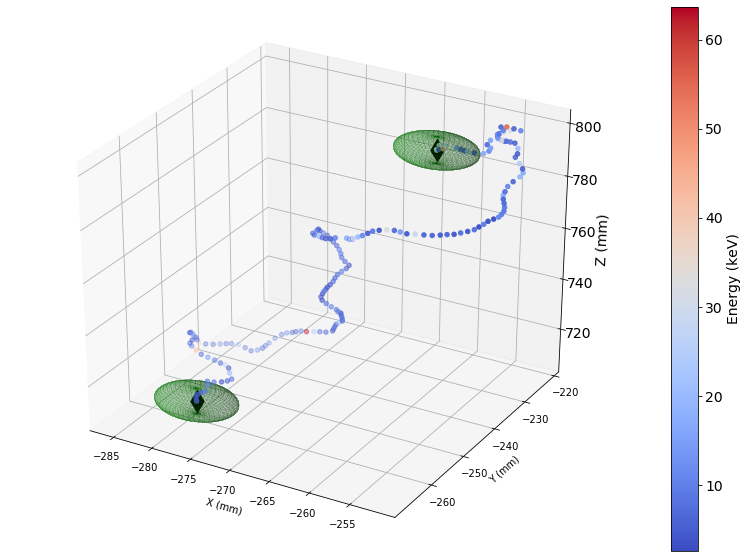

In [165]:
gt = GTrack(gtracks[0], event_id=0)
plot_gtrack(gt,
            rblob     = 5,
            autorange = True,
            weight    = 'energy',
            xrange    = (-500,500),
            yrange    = (-500,500),
            zrange    = (0,1000),
            figsize   = (14,10))

#### Difference between reconstructed and true extrema

In [166]:
gt.extremadf

,x,y,z,e,nhits
e1,-277.930145,-262.672485,714.104980,0.006838,1.0
e2,-261.045026,-230.878349,792.878299,0.017925,27.0


In [150]:
tebb.df

,x,y,z,time,energy,label
0,-273.207062,-255.572342,724.871460,0.348872,0.001073,ACTIVE
1,-261.039703,-230.863617,792.874023,0.523512,0.002869,ACTIVE


In [170]:
np.abs(gt.extremadf.x.values - tebb.df.x.values)

array([4.7230835 , 0.00532301])

In [171]:
np.abs(gt.extremadf.y.values - tebb.df.y.values)

array([7.10014343, 0.01473161])

In [172]:
np.abs(gt.extremadf.z.values - tebb.df.z.values)

array([1.07664795e+01, 4.27591962e-03])

#### Show the dependence of number of voxels with blob radius

In [173]:
nvox1_rb2 = voxels_in_blob(gt, rb=2, extreme ='e1')

In [174]:
nvox1_rb2.df 

,x,y,z,energy,nhits
0,-277.930145,-262.672485,714.104980,0.006838,1.0
1,-278.401489,-261.808929,714.141724,0.004334,1.0
2,-278.650177,-260.864594,714.042725,0.006018,1.0


In [175]:
X = np.arange(1,10, 0.1)

In [176]:
nvox1 = [len(voxels_in_blob(gt, rb, extreme ='e1').df) for rb in X]

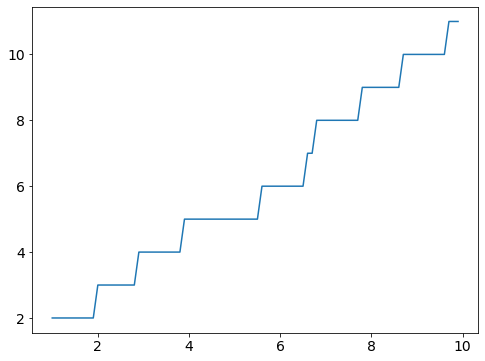

In [177]:
plt.plot(X, nvox1)

In [178]:
nvox2 = [len(voxels_in_blob(gt, rb, extreme ='e2').df) for rb in X]

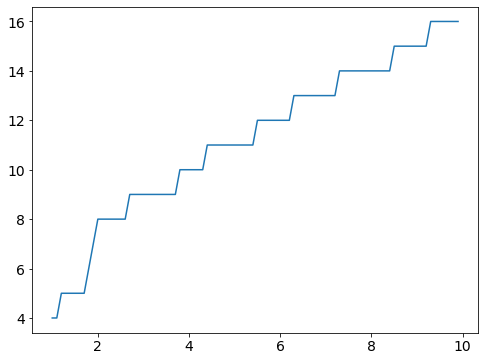

In [179]:
plt.plot(X, nvox2)

In [ ]:
def bb_stats(trs):
    

- The number of voxels increases rapidly until a radius of about 5 mm, then the slope is softer. 
- Thus, rb = 5 mm appears as a good choice

In [180]:
blob_energy(gt, rb = 5, extreme  ='e1')

32.43985353037715

In [181]:
blob_energy(gt, rb = 5, extreme  ='e2', unit=keV)

217.71334344521165

### The case of large voxels

In [184]:
vt5, _ = voxelize_hits(voxelHitsbb, bin_size = 5, baryc = True)

In [185]:
voxels = get_voxels_as_list(vt5)

In [186]:
minimum_d, inclusive_d = voxel_distances(voxels)

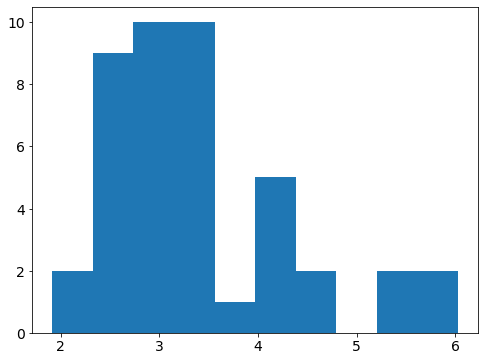

In [187]:
out = plt.hist(minimum_d)

In [188]:
contiguity = 8
gtracks = make_track_graphs(voxels, contiguity)
print(f'number of tracks for contiguity of {contiguity} is {len(gtracks)}')

number of tracks for contiguity of 8 is 1


In [189]:
gtrack = gtracks[0]

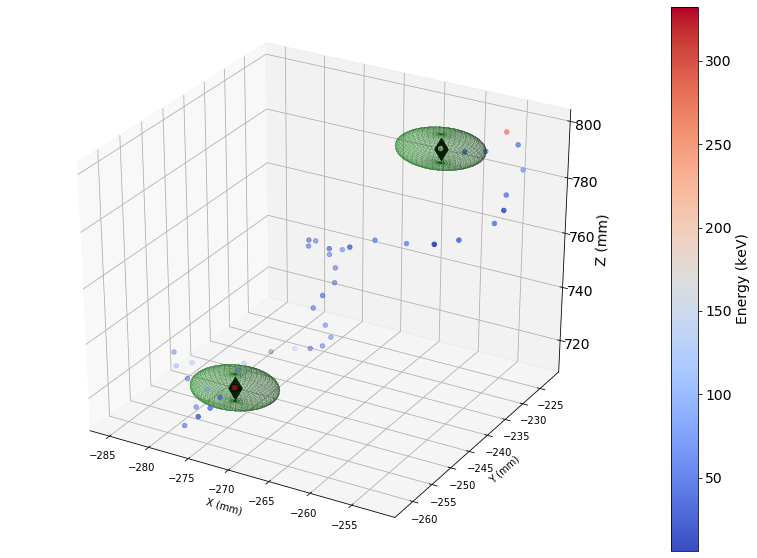

In [190]:
gt = GTrack(gtrack, event_id=0)
plot_gtrack(gt,
            rblob     = 5,
            autorange = True,
            weight    = 'energy',
            xrange    = (-500,500),
            yrange    = (-500,500),
            zrange    = (0,1000),
            figsize   = (14,10))

In [191]:
nvox1 = [len(voxels_in_blob(gt, rb, extreme ='e1').df) for rb in X]

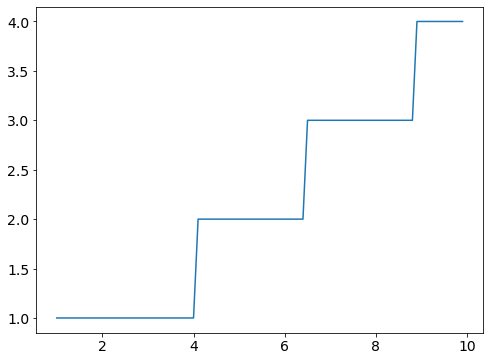

In [192]:
plt.plot(X, nvox1)

In [193]:
blob_energy(gt, rb = 5, extreme  ='e1')

354.2997636832297

In [194]:
blob_energy(gt, rb = 5, extreme  ='e2')

239.83800457790494